In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C import CAdaptive_C_RK4
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def apply_method(H, S, num_electrons, beta, eps):    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our C method
    c = CAdaptive_C_RK4(ovlp=S, H=H, num_electrons=num_electrons, dbeta=dbeta, epsilon=eps)
    c.propagate(beta)
    
    return c

In [4]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    coeff = 2 * num_electrons / S.trace() * S
    return coeff @ linalg.funm(inv_S @ H, lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

In [5]:
def successive(H, S, num_electrons, beta):
    # Define dbeta
    dbeta = beta / 100
    
    # Create dictionary of common parameters
    params = dict(ovlp=S, H=H, num_electrons=num_electrons)
    
    # Create list of epsilon values to use
    eps = [1e-1, 1e-2, 1e-3, 1e-4]
    
    # Create list for storing results
    results = []
    
    # Run the first step and append to list
    c = CAdaptive_C_RK4(dbeta=dbeta, epsilon=1e-2, **params)
    c.propagate(beta)
    results.append(c)
    
    # Run second step and append
    c2 = CAdaptive_C_RK4(dbeta=c.dbeta, epsilon=1e-3, rho=c.rho, beta=c.beta, **params)
    c2.propagate(beta)
    results.append(c2)
    
    # Run second step and append
    c3 = CAdaptive_C_RK4(dbeta=c2.dbeta, epsilon=1e-4, rho=c.rho, beta=c2.beta, **params)
    c3.propagate(beta)
    results.append(c3)
    
    return results

In [6]:
def plot_results_fd_vs_c(num_electrons, fd, c):
    H = c.H
    S = c.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    plt.figure(1)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, S)[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c.rho, S)[::-1], 'r^-', label="Can. DMM")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_pop.png", format='png', dpi=300)
    print(c.beta)
    
    # Plot increments of dbeta that our method took
    plt.figure(2)
    plt.title("Variable step method in action - " +str(num_electrons) + " electrons")
    plt.plot(c.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    plt.figure(3)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(c.num_electron_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    plt.figure(4)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(c.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_chem_pot.png", format='png', dpi=300)
    
    """
    # Imshow of eigenvalues
    plt.figure(5)
    plt.imshow(np.array(c.eigenvalues).real, origin='lower', aspect='1')
    plt.xlabel("eigenvalues")
    plt.ylabel("steps")
    plt.title("Imshow of eigenvalues - " + str(num_electrons) + " electrons")
    plt.colorbar()
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_eig_imshow.png", format='png', dpi=300)
    """
    
    # Check beta vs step size
    plt.figure(6)
    beta_vals = np.cumsum(c.beta_increments)
    print(beta_vals[0])
    plt.plot(c.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    plt.figure(7)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.semilogy(beta_vals, (c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - E.min")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    plt.figure(8)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_steps.png", format='png', dpi=300)
    
     # Plot heat capacity
    plt.figure(9)
    plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons")
    t_vals = 1 / np.cumsum(c.beta_increments) * 1 / 3.168e-6
    temp = np.pi ** 2 / 2 * 2/ 13.49e4 * t_vals + 12*np.pi**4/5 * 3.168e-6 * t_vals ** 3 / 433 ** 3
    #alpha = temp[-1] / c.cv[-1]
    plt.plot(t_vals[95:], np.array(c.cv[95:])/num_electrons*2)
    plt.plot(t_vals[95:], temp[95:], '--')
    plt.xlabel("T")
    plt.ylabel("C_v/k")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_cv.png", format='png', dpi=300)
    
    plt.figure(10)

In [7]:
def successive_plots(num_electrons, c_direct, c_succ):
    H = c_direct.H
    S = c_direct.ovlp
    
    # Combine eigenvalues from successive steps
    c_succ_eigenvalues = np.vstack(
        [_.eigenvalues for _ in c_succ]
    )

    # Combine beta increments from successive steps
    c_succ_beta_increments = np.hstack(
        [_.beta_increments for _ in c_succ]
    )

    # Plot beta increments
    plt.figure(1)
    plt.title("Successive dbeta changes - " + str(num_electrons) + " electrons")
    plt.plot(c_succ_beta_increments)
    plt.xlabel("steps")
    plt.ylabel("dbeta")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_successive_dbeta_inc.png", format='png', dpi=300)
    
    """
    # Print final beta of successive steps and imshow eigenvalue spectra
    print(c_succ[-1].beta)
    plt.figure(2)
    plt.title("Successive Eigenvalues - " + str(num_electrons) + " electrons")
    plt.imshow(c_succ_eigenvalues.real, origin='lower', aspect=1)
    plt.xlabel("Population Index")
    plt.ylabel("Steps")
    plt.colorbar()
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_successive_eig_imshow.png", format='png', dpi=300)
    """
    
    # Print results for direct and successive approaches
    plt.figure(3)
    plt.title("Direct vs Successive - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c_succ[-1].rho)[::-1], '*-', label="Successive")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c_direct.rho)[::-1], '*-', label="Direct")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_direct_vs_successive_pops.png", format='png', dpi=300)
    
    # Combine beta increments from successive steps
    c_succ_energy_vals = np.hstack(
        [_.energy_vals for _ in c_succ]
    )
    plt.figure(4)
    plt.title("Energy values - " + str(num_electrons) + " electrons")
    plt.plot(c_succ_energy_vals)
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_successive_energy_vals.png", format='png', dpi=300)

In [20]:
def plot_results_omega_vs_P(num_electrons, sqrt_c, c):
    H = c.H
    S = c.ovlp
    rho = sqrt_c.omega.conj().T @ sqrt_c.omega
    num_fig = 1
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    plt.figure(num_fig)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c.rho, S)[::-1], 'r^-', label="Normal")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(rho, S)[::-1], 'bo', label="Sqrt")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/sqrt_vs_normal.png", format='png', dpi=300)
    print(c.beta)
    num_fig += 1
    
    # Plot increments of dbeta that our method took
    plt.figure(num_fig)
    plt.title("Variable step method in action - " +str(num_electrons) + " electrons")
    plt.plot(c.beta_increments, 'r^-', label='Normal')
    plt.plot(sqrt_c.beta_increments, 'bo', label='Sqrt')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_dbeta_inc.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot number of electrons
    plt.figure(num_fig)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(c.num_electron_list, 'r^-', label='Normal')
    plt.plot(sqrt_c.num_electron_list, 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.ylim([31, 33])
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_num_electrons.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot chemical potential
    plt.figure(num_fig)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(c.mu_list, 'r^-', label='Normal')
    plt.plot(sqrt_c.mu_list, 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_chem_pot.png", format='png', dpi=300)
    num_fig += 1
    
    # Check beta vs step size
    plt.figure(num_fig)
    beta_vals = np.cumsum(c.beta_increments)
    sqrt_beta_vals = np.cumsum(sqrt_c.beta_increments)
    print(beta_vals[0])
    plt.plot(c.beta_increments, beta_vals, 'r^-', label='Normal')
    plt.plot(sqrt_c.beta_increments, sqrt_beta_vals, 'bo', label='Sqrt')
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_beta_vs_stepsize.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot energy values
    plt.figure(num_fig)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.semilogy(beta_vals, (c.energy_vals - min(c.energy_vals))[:-1], 'r^-', label='Normal')
    plt.semilogy(sqrt_beta_vals, (sqrt_c.energy_vals - min(sqrt_c.energy_vals))[:-1], 'bo', label='Sqrt')
    plt.xlabel("beta")
    plt.ylabel("E(beta) - E.min")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_beta.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot energy values
    plt.figure(num_fig)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((c.energy_vals - min(c.energy_vals))[:-1], 'r^-', label='Normal')
    plt.semilogy((sqrt_c.energy_vals - min(c.energy_vals))[:-1], 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_steps.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot heat capacity
    n = int(beta_vals.shape[0] - 10)
    plt.figure(num_fig)
    plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons")
    t_vals = 1 / beta_vals * 1 / 3.168e-6
    temp = np.pi ** 2 / 2 * 2/ 13.49e4 * t_vals + 12*np.pi**4/5 * 3.168e-6 * t_vals ** 3 / 433 ** 3
    #alpha = temp[-1] / c.cv[-1]
    plt.plot(t_vals[n:], np.array(c.cv[n:])/num_electrons*2, label='Calc')
    plt.plot(t_vals[n:], temp[n:], '--', label='Exact')
    plt.xlabel("T")
    plt.ylabel("C_v/k")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_cv.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot heat capacity from sqrt approach
    n = int(sqrt_beta_vals.shape[0] - 10)
    plt.figure(num_fig)
    plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons (sqrt approach)")
    sqrt_t_vals = 1 / sqrt_beta_vals * 1 / 3.168e-6
    temp = np.pi ** 2 / 2 * 2/ 13.49e4 * sqrt_t_vals 
    temp += 12*np.pi**4/5 * 3.168e-6 * sqrt_t_vals ** 3 / 433 ** 3
    plt.plot(sqrt_t_vals[n:], np.array(sqrt_c.cv[n:])/num_electrons*2, label='Calc')
    plt.plot(sqrt_t_vals[n:], temp[n:], '--', label='Exact')
    plt.xlabel("T")
    plt.ylabel("C_v/k")
    plt.legend(numpoints=1)
    num_fig += 1

In [9]:
# Define path for matrices
matrices_path = "larger_matrices/"

### 16 x 16 case

In [10]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 32
beta = 100

# Run method
c_16 = apply_method(H_16, S_16, num_electrons, beta, 1e-2)
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, c_16.beta, c_16.mu)

# Check that number of electrons did not change
print("FD: ", ferm_exact_16.trace())
print("C: ", c_16.rho.trace())

funm result may be inaccurate, approximate err = 1
FD:  31.95641069864164
C:  31.99999999999999


102.01447047272325
0.01


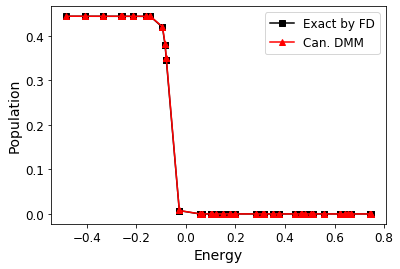

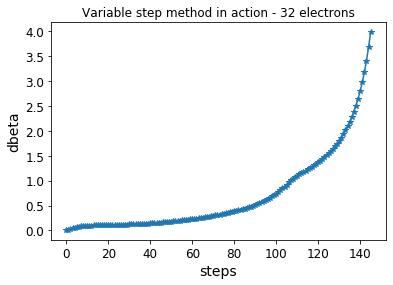

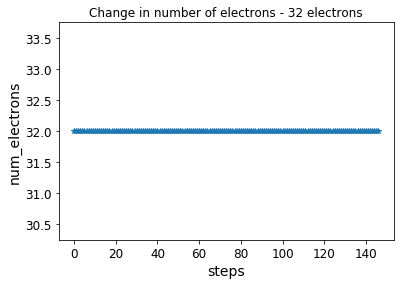

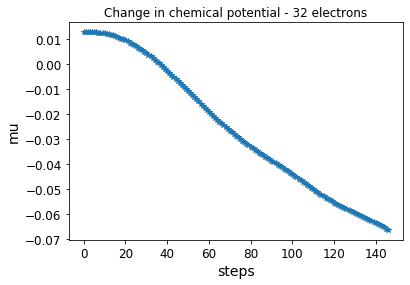

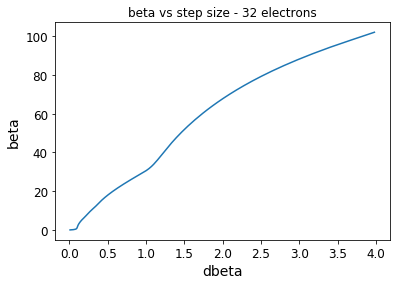

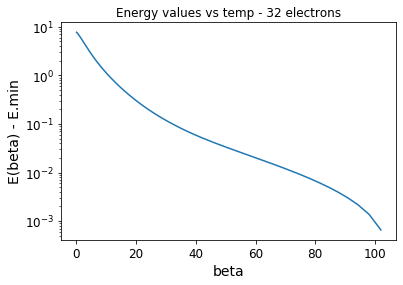

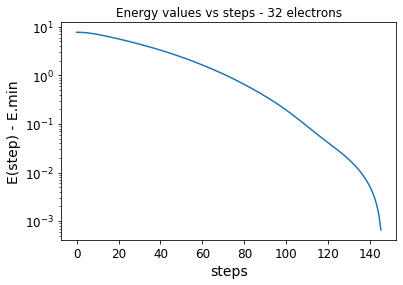

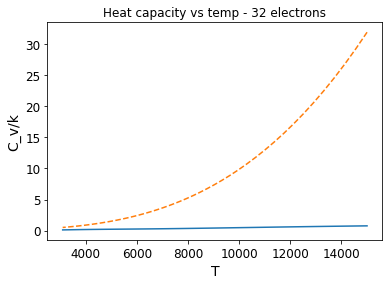

<Figure size 432x288 with 0 Axes>

In [11]:
plot_results_fd_vs_c(num_electrons, ferm_exact_16, c_16)

In [12]:
dbeta = beta / 10000

# Run our C method
sqrt_c_16 = CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, num_electrons=num_electrons, dbeta=dbeta, epsilon=1e-2)
sqrt_c_16.propagate(beta)
print(sqrt_c_16.beta)

101.32229113497998


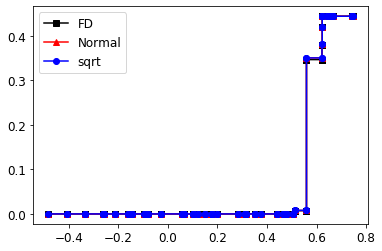

In [13]:
n = 0
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(ferm_exact_16, S_16)[n:], 'ks-', label='FD')
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(c_16.rho, S_16)[n:], 'r^-', label='Normal')
rho = sqrt_c_16.omega.conj().T @ sqrt_c_16.omega
#rho = S_16 @ sqrt_gc.q @ sqrt_gc.q.conj().T
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(rho, S_16)[n:], 'bo-', label='sqrt')
plt.legend(numpoints=1)

In [14]:
exact_eigs = linalg.eigvalsh(ferm_exact_16, S_16)
norm_eigs = linalg.eigvalsh(c_16.rho, S_16)
sqrt_eigs = linalg.eigvalsh(rho, S_16)
print("Exact vs normal: ", linalg.norm(exact_eigs - norm_eigs))
print("Exact vs sqrt: ", linalg.norm(exact_eigs - sqrt_eigs))

Exact vs normal:  0.008776077198999751
Exact vs sqrt:  0.008680860141694046


102.01447047272325
0.01


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, ord

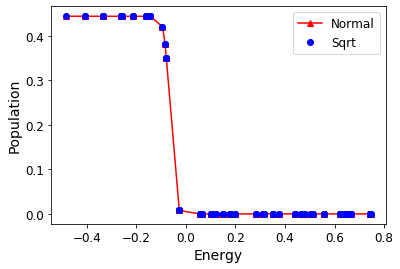

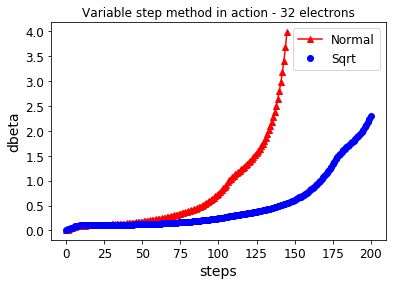

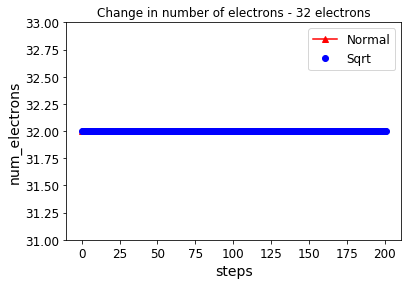

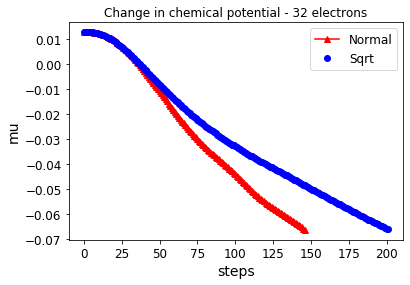

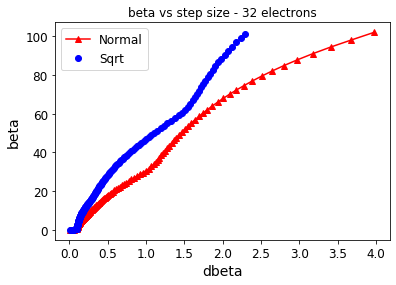

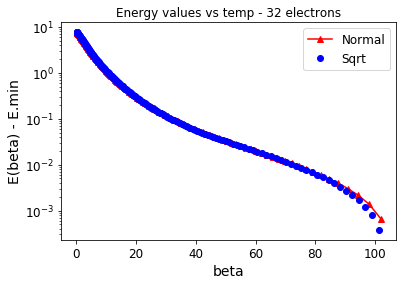

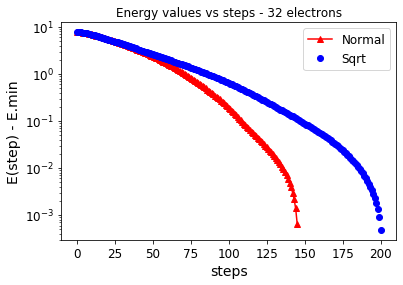

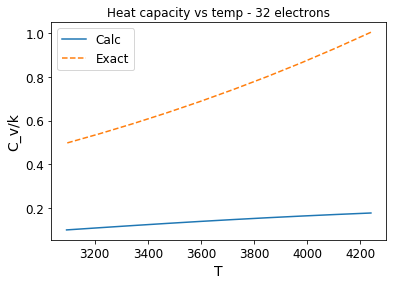

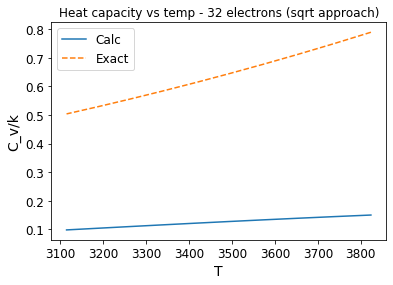

In [21]:
plot_results_omega_vs_P(num_electrons, sqrt_c_16, c_16)

In [11]:
# Use successive steps
c_succ_16 = successive(H_16, S_16, num_electrons, beta)

Energy_next > energy
Energy_next > energy


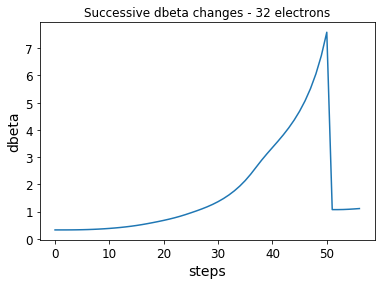

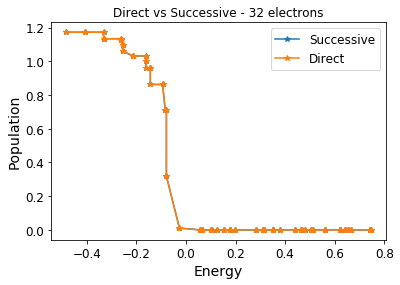

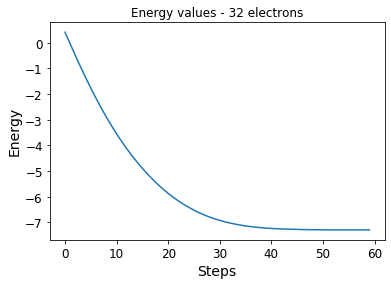

In [12]:
successive_plots(num_electrons, c_16, c_succ_16)

### 54 x 54 case

In [13]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 108

# Run method
c_54 = apply_method(H_54, S_54, num_electrons, beta, 1e-2)
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, c_54.beta, c_54.mu)

# Check that number of electrons did not change
print("FD: ", ferm_exact_54.trace())
print("C: ", c_54.rho.trace())

funm result may be inaccurate, approximate err = 1
FD:  (107.89521117383546-2.439454888092385e-18j)
C:  108.00000000000001


103.07143080433578
0.01


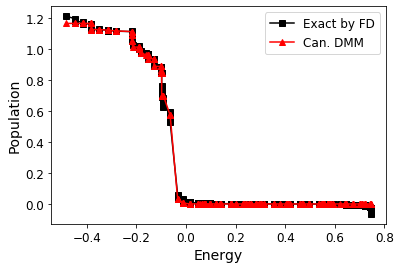

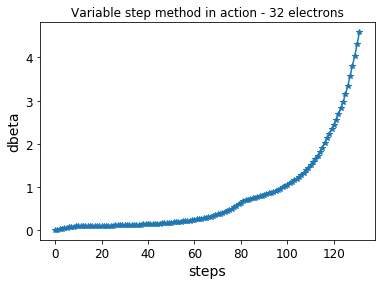

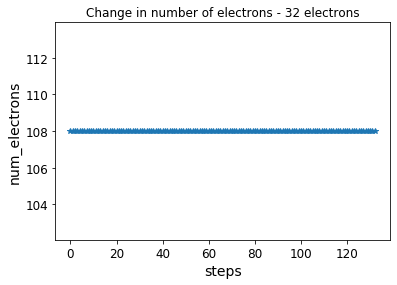

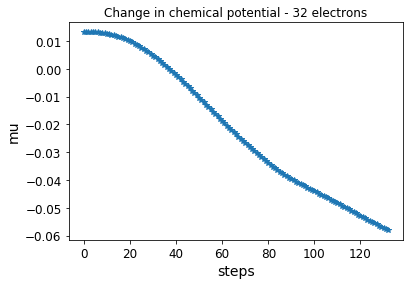

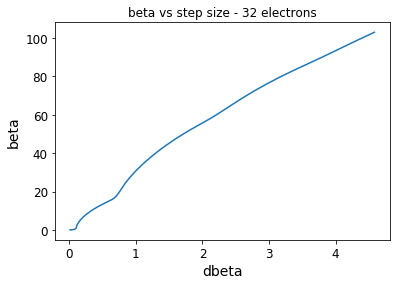

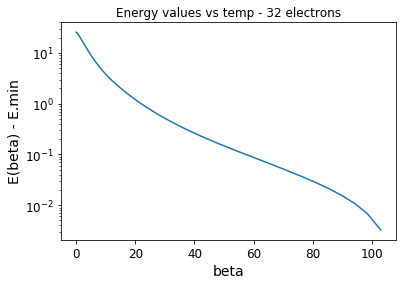

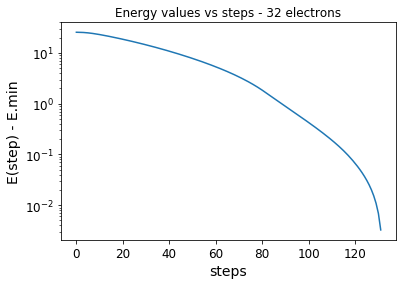

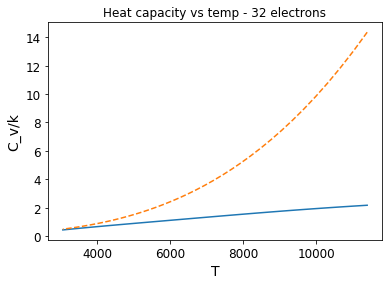

<Figure size 432x288 with 0 Axes>

In [67]:
plot_results_fd_vs_c(num_electrons, ferm_exact_54, c_54)

In [15]:
# Use successive steps
c_succ_54 = successive(H_54, S_54, num_electrons, beta)

Energy_next > energy
Energy_next > energy


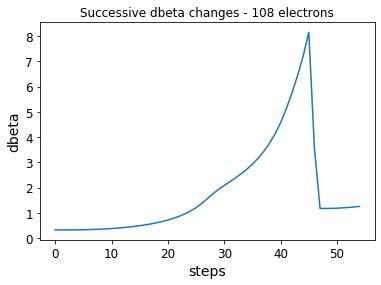

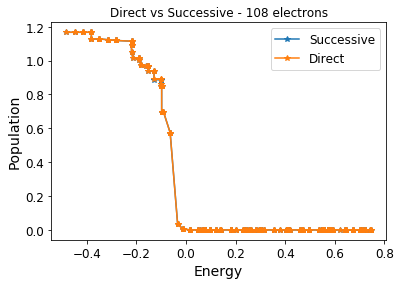

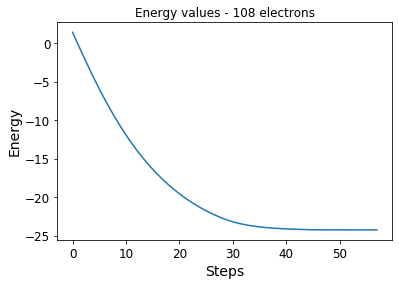

In [16]:
successive_plots(num_electrons, c_54, c_succ_54)

### 128 x 128 case

In [17]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 256

# Run method
c_128 = apply_method(H_128, S_128, num_electrons, beta, 1e-2)
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, c_128.beta, c_128.mu)

# Check that number of electrons did not change
print("FD: ", ferm_exact_128.trace())
print("C: ", c_128.rho.trace())

funm result may be inaccurate, approximate err = 1
FD:  (255.96971303536515+5.421010862427522e-20j)
C:  255.99999999999963


101.74348255334539
0.01


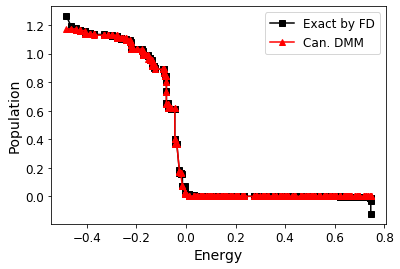

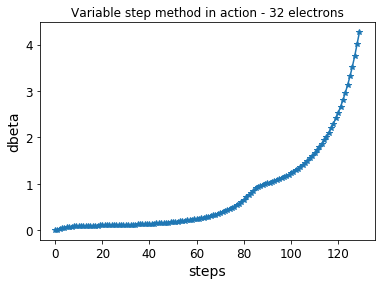

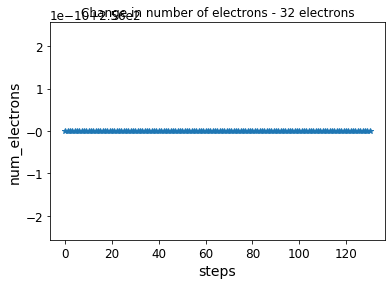

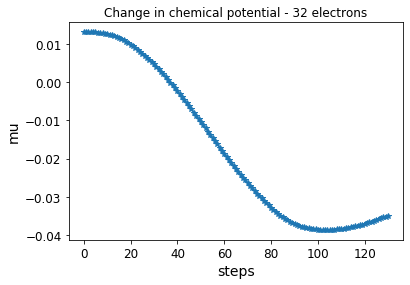

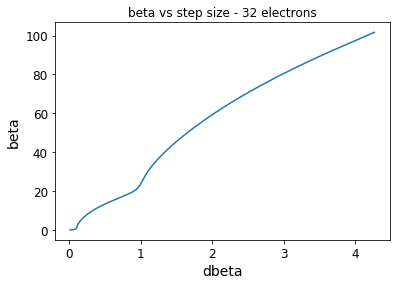

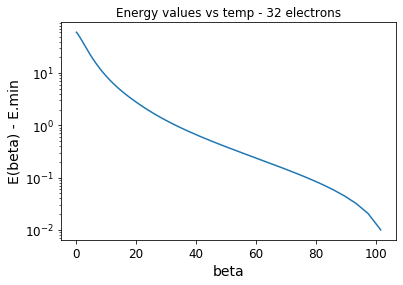

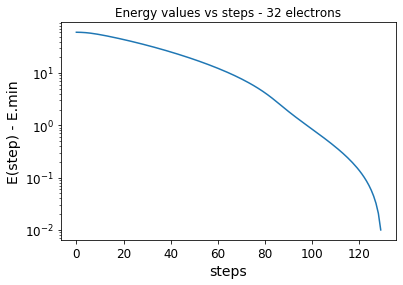

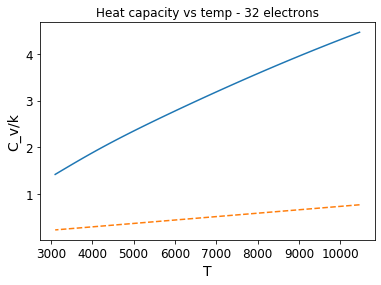

<Figure size 432x288 with 0 Axes>

In [63]:
plot_results_fd_vs_c(num_electrons, ferm_exact_128, c_128)

In [37]:
(2.025e6 - 1.85e6) / 2.025e6

0.08641975308641975

In [19]:
# Use successive steps
c_succ_128 = successive(H_128, S_128, num_electrons, beta)

Energy_next > energy
Energy_next > energy


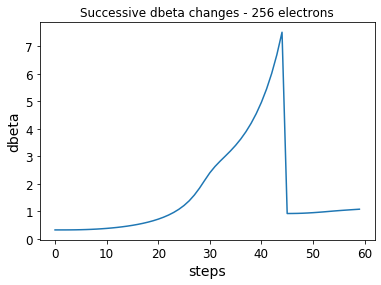

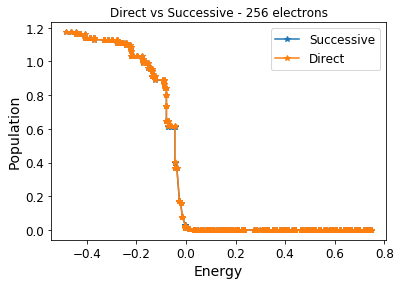

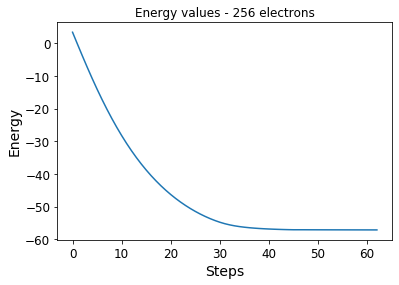

In [20]:
successive_plots(num_electrons, c_128, c_succ_128)

### 250 x 250 case

In [21]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 500

# Run method
c_250 = apply_method(H_250, S_250, num_electrons, beta, 1e-2)
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, c_250.beta, c_250.mu)

# Check that number of electrons did not change
print("FD: ", ferm_exact_250.trace())
print("C: ", c_250.rho.trace())

funm result may be inaccurate, approximate err = 1
FD:  499.70351802874313
C:  499.99999999999994


105.44162198531968
0.01


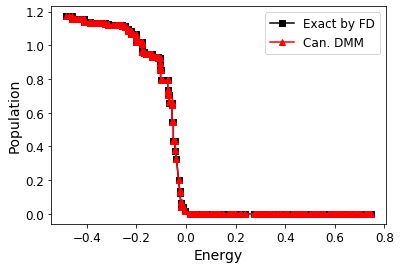

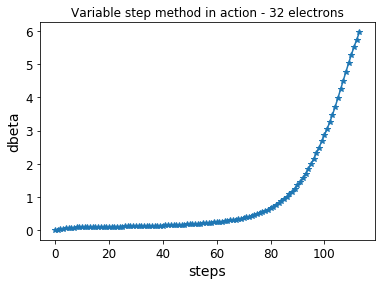

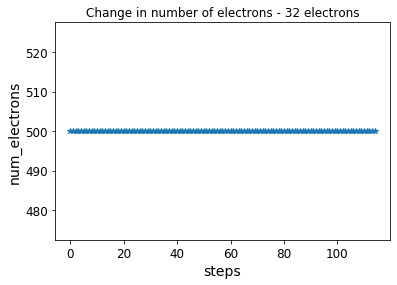

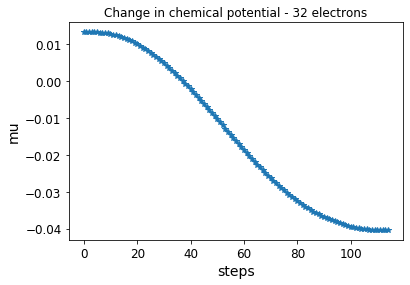

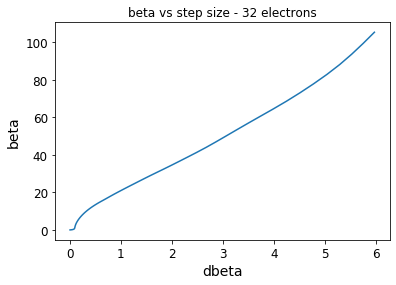

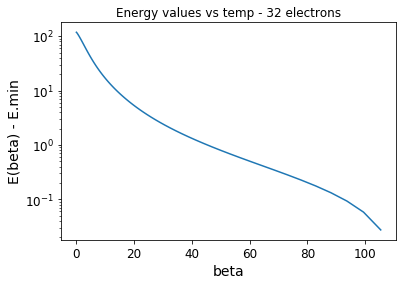

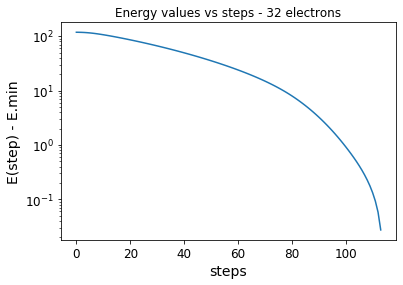

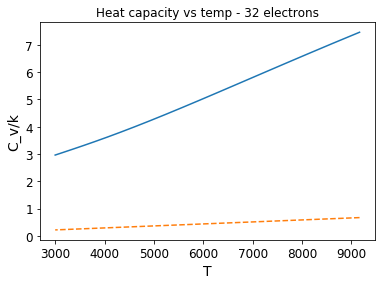

<Figure size 432x288 with 0 Axes>

In [64]:
plot_results_fd_vs_c(num_electrons, ferm_exact_250, c_250)

In [23]:
# Use successive steps
c_succ_250 = successive(H_250, S_250, num_electrons, beta)

Energy_next > energy
Energy_next > energy


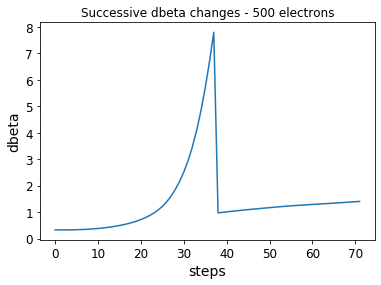

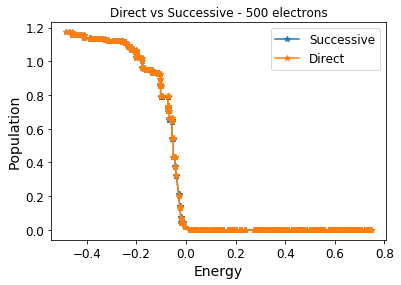

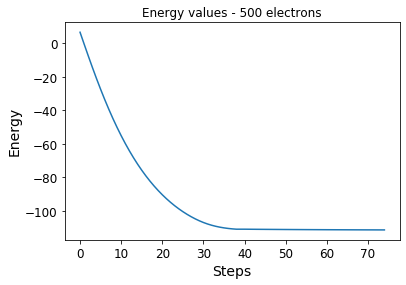

In [24]:
successive_plots(num_electrons, c_250, c_succ_250)

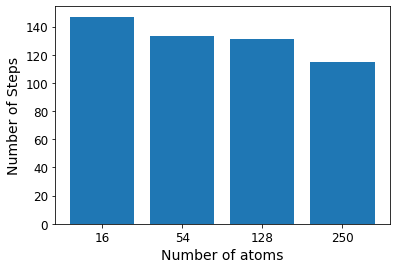

In [25]:
x = [1, 2, 3, 4]
y = [len(c_16.energy_vals), len(c_54.energy_vals), len(c_128.energy_vals), \
     len(c_250.energy_vals)]
ax = plt.subplot()
ax.bar(x, y)
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
ax.set_xlabel("Number of atoms")
#plt.title("C Steps vs Num Atoms")
plt.savefig("c_steps_vs_size.png", format='png', dpi=300)